Use **pip install gym** to install the required package. See further information on 

https://gym.openai.com/docs/

Use **pip install pyglet** to install pyglet. This package draws (renders) the game on the screen.

In [2]:
import gym

In [3]:
env = gym.make('CartPole-v0')

array([ 0.0412548 , -0.04389008, -0.02926047, -0.02530798], dtype=float32)

In [18]:
# see how the environment works
from time import sleep

# always call reset at the start of game
env.reset()

for _ in range(1000):
    # draw the game
    env.render()

    # randomly choose an action, action = 0 or 1 in this game
    action = env.action_space.sample()

    # take this action
    state, reward, done, info = env.step(action)

    # if done == True, then the game ends
    if done == True:
        break
    sleep(0.01)
sleep(1)

# close the window
env.close()

Our aim of the game: the agent plays more than 200 actions before the game ends (the longer the better).

In [74]:
import numpy as np
import torch

model = torch.nn.Sequential(
    torch.nn.Linear(4, 50),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(50, 30),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(30, 2),
    torch.nn.Softmax(dim=-1)
)

def loss_f(a, b):
    return - torch.sum(b * torch.log(a))

optimizer = torch.optim.Adam(model.parameters())

In [75]:
from tqdm import tqdm 
max_moves = 200
gamma = 0.99
epochs = 2000
score = []
for epoch in tqdm(range(epochs)):
    # restart a new game and obtain the current state
    state2 = env.reset()
    gameover = False
    replay = []

    for t in range(max_moves):
        state = torch.Tensor(state2)
        prob = model( state )
        action = np.random.choice((0,1), p = prob.detach().numpy())
        state2, _, gameover, info = env.step(action)
        replay.append((state, prob, action))
        if gameover:
            break 
    
    length = len(replay)
    score.append(length) # the longer the better

    state_batch   = torch.cat([s for (s,p,a) in replay]).reshape((length,4))
    predict_batch = torch.cat([p for (s,p,a) in replay]).reshape((length,2))
    action_batch  = torch.Tensor([a for (s,p,a) in replay])

    # the corresponding reward is decreasing (nearer to the end receives fewer rewards)
    reward_batch  = torch.arange(length,0,-1)

    reward_batch = torch.pow(gamma, torch.arange(length)) * reward_batch
    reward_batch *= 1. / torch.max(reward_batch)

    predict = predict_batch.gather(dim=1, index=action_batch.long().view(-1,1)).squeeze()

    loss = loss_f(predict, reward_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

100%|██████████| 2000/2000 [01:35<00:00, 21.00it/s]


Note : the training speed is slowing down because the agent plays longer time after training!

We shall see it is often the case that the agent can play up to 200 steps after training.

In [78]:
print(score[-20:])

[200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 196, 200, 200, 200, 200]


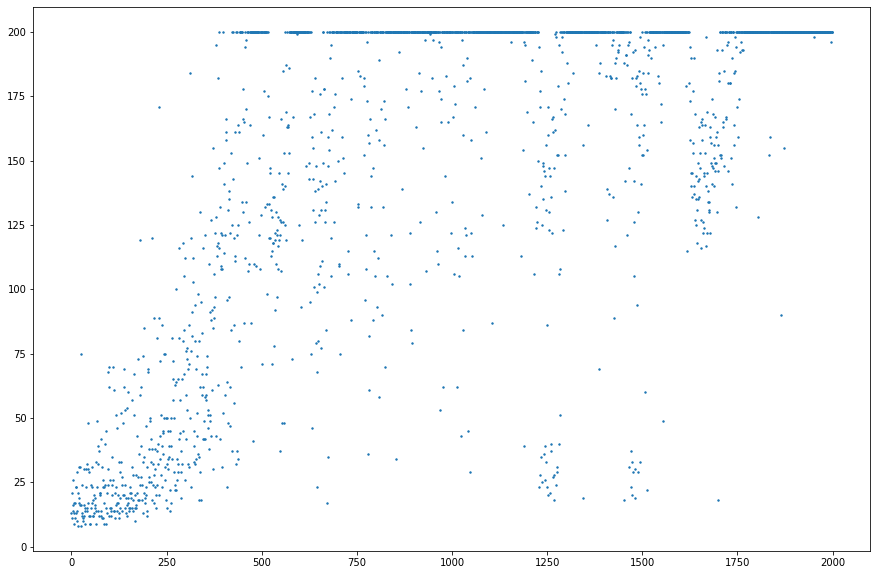

In [81]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.scatter(np.arange(len(score)), score, s=2)